# Monte Carlo - Unidad 2, Sesion 3 - Ejercicio

**Autor**: Carlos M. Martinez, marzo-abril 2022. Reenviado 2025.

**Email**: carlosm@fing.edu.uy, carlos@cagnazzo.uy

## Problema

Se desea estimar el volumen de una region R de [0,1]^6 definida por todos los puntos de la hiper-esfera de centro (0.45, 0.5, 0.6, 0.6, 0.5, 0.45) y radio 0.35 que ademas cumplen con las restricciones 3x1 + 7x4 <= 5; x3+x4 <= 1; x1-x2-x5+x6 >= 0

### Entrega 2 - Ejercicio 3.1

#### Parte a: 

**[Letra]** Implementar un programa que reciba como parametro la
cantidad de replicaciones n a realizar, y emplee Monte Carlo para
calcular (e imprimir) la estimación del volumen de R, y la desviación
estandar de este estimador. Incluir codigo para calcular el tiempo de
calculo empleado por el programa. Utilizar el programa con n = 10^4 y
luego con n = 10^6 para estimar el volumen de R. Discutir si los dos
valores obtenidos parecen consistentes.
(en la sesi´on 5 se continuar´a este ejercicio).

In [1]:
# Instalar dependencias
# !pip3 install -q -r requirements.txt

In [2]:
import random
import math
import tabulate
import time
random.seed()

def sortearPuntoRN(dim=2):
    """
    Seortea un punto en R^N dentro del hiper-cubo [0,1]^N
    """
    punto = []
    for n in range(0, dim):
        punto.append(random.uniform(0.0, 1.0))
    # end for

    return punto
# end fun sortearPuntoRN

def puntoDentroVolumen(punto, restricciones=True):
    """
    Devuelve 0 o 1 si un punto esta fuera o dentro de un cierto volumen.
    Si restricciones es "false", el volumen es la hiperesfera en R6
    """

    # Para que este dentro del volumen tiene que estar dentro de la esfera 
    # y ademas cumplir con las restricciones adicionales

    dentro = 1
    fuera = 0

    # chequeo 1 : dentro de esfera

    d = math.sqrt(
        (punto[0]-0.45)**2 +
        (punto[1]-0.5)**2 +
        (punto[2]-0.6)**2 +
        (punto[3]-0.6)**2 +
        (punto[4]-0.5)**2 +
        (punto[5]-0.45)**2 
    )

    # si la distancia es mayor al radio, esta fuera
    if (d>=0.35) : 
        return fuera

    if restricciones:
        # restriccion 1
        if 3*punto[0] + 7*punto[3] > 5:
            return fuera
        # restriccion 2
        if punto[2]+punto[3] > 1:
            return fuera
        # restriccion 3
        if punto[0]-punto[1]-punto[4]+punto[5] < 0:
            return fuera
    else:
        return dentro

    return dentro
# end fun punto dentro del volumen

# sortearPuntoRN(6)

In [3]:
# Implemento pseudocodigo Montecarlo

import functools
from pathos.multiprocessing import ProcessPool as Pool   

#@functools.lru_cache(maxsize=128)
def MetodoMonteCarlo(N, FVolumen):
    """
    Implementa el pseudocodigo de MC
    N: cantidad de muestras
    FVolumen: funcion que define el volumen, devuelve 0 si el punto esta fuera, 1 si esta dentro
    """
    random.seed()
    t0 = time.perf_counter()
    S = 0
    for j in range(0, N):
        punto = sortearPuntoRN(6)
        if FVolumen(punto):
            phi = 1
        else: 
            phi = 0
        S = S + phi
    # end for
    VolR = S / N
    VarVorR = (S/N)*(1-S/N)/(N-1)
    return (VolR, VarVorR, S,  time.perf_counter()-t0)
# end def

# Version paralelizada de Montecarlo
def MetodoMonteCarloParalelo(N, FVolumen, hilos):
    """
        version paralelizada del montecarlo
        N: numero de muestras
        FVolumen: funcion que implementa el volumen
        hilos: cantidad de hilos en el pool de tareas
    """
    t0 = time.perf_counter()

    args1 = []
    args2 = [] 
    for x in range(0,hilos):
        args1.append( math.ceil(N/hilos) )
        args2.append(FVolumen)
    
    p = Pool(hilos)
    resultados = p.map(MetodoMonteCarlo, args1, args2 )
    #print(resultados)

    # unir los resultados para producir el resultado final
    Stotal = 0
    Ntotal = 0
    for i in range(0, hilos):
        Stotal = Stotal + resultados[i][2]
        Ntotal = Ntotal + math.ceil(N/hilos)
    #
    VolR = Stotal / Ntotal
    VarVorR = (Stotal/Ntotal)*(1-Stotal/Ntotal)/(Ntotal-1)

    return (VolR, VarVorR, Stotal,  time.perf_counter()-t0)
   
# end def

VolH = math.pi**3*(0.35**6)/6

# Caclulo del volumen de la hiperesfera por MMC
(VolR, VarVolR, S, execTime) = MetodoMonteCarlo(10**6, lambda x: puntoDentroVolumen(x, False))
#print(MetodoMonteCarloParalelo(10**6, lambda x: puntoDentroVolumen(x, False), 4))

#### Verificación

Comparamos el volumen sin restricciones con el volumen calculado analiticamente de la hiperesfera en R6

In [4]:
print("Volumen hiper esfera por MMC = {:e}, Varianza = {:e}".format(VolR, VarVolR))
print(" ")
print("Volumen hiper esfera analitico = {:e}, diferencia MMC - analitico = {:.3f}%".format(VolH, (VolH-VolR)/VolR*100))

Volumen hiper esfera por MMC = 9.450000e-03, Varianza = 9.360707e-09
 
Volumen hiper esfera analitico = 9.499629e-03, diferencia MMC - analitico = 0.525%


Con un millon de muestras tenemos una diferencia de menos de 1% entre el volumen calculado de forma analitica y el volumen calculado por Montecarlo.

#### Ejecución para diferentes tamaños de muestra

En esta seccion corremos MMC para calcular el volumen con restricciones para diferentes tamanos de muestra.

In [15]:
table = [ ['N', 'S', 'Vol hiperesfera (analitico)', 'Vol hiperesfera+restricciones', 'Varianza', 'Tiempo (s)'] ]

for n in [2, 3, 4, 5, 6, 7, 8]:
    (VolR, VarVolR, S, execTime) = MetodoMonteCarlo(10**n, lambda x: puntoDentroVolumen(x, True))
    table.append( [10**n, S, "{:3e}".format(VolH), "{:3e}".format(VolR), "{:3e}".format(VarVolR), "{:3f}".format(execTime)] )


tabulate.tabulate(table, tablefmt='html')

N,S,Vol hiperesfera (analitico),Vol hiperesfera+restricciones,Varianza,Tiempo (s)
100,0,9.499629e-03,0.000000e+00,0.000000e+00,0.000253
1000,0,9.499629e-03,0.000000e+00,0.000000e+00,0.002405
10000,1,9.499629e-03,1.000000e-04,1.000000e-08,0.023694
100000,20,9.499629e-03,2.000000e-04,1.999620e-09,0.113212
1000000,289,9.499629e-03,2.890000e-04,2.889168e-10,0.922231
10000000,2845,9.499629e-03,2.845000e-04,2.844191e-11,9.073884
100000000,28403,9.499629e-03,2.840300e-04,2.839493e-12,92.401960


Entre las corridas de 10mil y 1millon de muestras hay una diferencia de un 7.6% aproximadamente. Los resultados parecen coherentes en el sentido de que al aumentar el tamano de la muestra el resultado parece tender a un valor y no parece diverger. La varianza estimada tambien decrece al aumentar el tamano de la muestra, otro resultado esperable.

El volumen determinado para la hiperesfera con restricciones es consistentemente menor al volumen de la hiperesfera sin restricciones, lo cual tiene sentido ya que las restricciones justamente eliminan puntos del volumen en cuestión.

#### Paralelización de operaciones

Implemento la misma estimación de Montecarlo pero utilizando una implementación paralela, en este caso con 4 hilos.

In [18]:
table = [ ['N', 'S', 'Vol hiperesfera (analitico)', 'Vol hiperesfera+restricciones', 'Varianza', 'Tiempo (s)'] ]

for n in [2, 3, 4, 5, 6, 7, 8, 9]:
    (VolR, VarVolR, S, execTime) = MetodoMonteCarloParalelo(10**n, lambda x: puntoDentroVolumen(x, True), 8)
    table.append( [10**n, S, "{:3e}".format(VolH), "{:3e}".format(VolR), "{:3e}".format(VarVolR), "{:3f}".format(execTime)] )


tabulate.tabulate(table, tablefmt='html')

N,S,Vol hiperesfera (analitico),Vol hiperesfera+restricciones,Varianza,Tiempo (s)
100,0,9.499629e-03,0.000000e+00,0.000000e+00,0.012158
1000,2,9.499629e-03,2.000000e-03,1.997998e-06,0.012879
10000,2,9.499629e-03,2.000000e-04,1.999800e-08,0.020425
100000,26,9.499629e-03,2.600000e-04,2.599350e-09,0.069082
1000000,314,9.499629e-03,3.140000e-04,3.139017e-10,0.158794
10000000,2873,9.499629e-03,2.873000e-04,2.872175e-11,1.278250
100000000,28135,9.499629e-03,2.813500e-04,2.812708e-12,12.958274
1000000000,283064,9.499629e-03,2.830640e-04,2.829839e-13,131.792319


### Entrega 2 : Ejercicio 4.1

**[Letra]** 1. Comparar y discutir la dependencia de los criterios de peor caso nC,
nN, nH frente a los parámetros epsilon y δ.

_En el caso de nC:_

- Si dejamos epsilon fijo, el tamaño de la muestra tiende a infinito de forma similar a 1/x (cuando x tiende a cero)
- Si dejamos delta fijo, tiende a infinito como 1/x^2

**[Letra]** 2. Calcular nC, nN, nH para epsilon = 0:01, δ = 0:001; 0:01; 0:05

_Nota: utilizo la funcion scipy.stats.norm.ppf del paquete SciPy para implementar la inversa de la normal_

In [6]:
from scipy.stats import norm

# Formula de Chebyshev
def tamMuestraChebyshev(epsilon, delta):
    nc =  1.0 / (4.0 * delta * epsilon**2)
    return math.ceil(nc)
#

# Formula Teo Central Limite
def tamMuestraTeoCentralLimite(epsilon, delta):
    x = norm.ppf(1.0 - delta/2.0)
    # nn = norm.ppf(x)**2
    return math.ceil( ( x/ (2.0*epsilon) ) **2 )
    # return x
# 

# Formula de Hoeffding
def tamMuestraHoeffding(epsilon, delta):
    """
    Estimacion del tamano de muestra segun Hoeffding.
    epsilon: error
    delta: confianza
    """
    num = 2 * math.log(2/delta)
    den = 4 * epsilon**2
    return math.ceil(num/den)
# end def

tabla2 = [ ['estimador', 'epsilon', 'delta', 'tam. muestra'] ]

epsilon = 0.01
for delta in [0.001, 0.01, 0.05]:
    tm_cheby = tamMuestraChebyshev(epsilon, delta)
    tabla2.append( ['cheby', epsilon, delta, f'{tm_cheby:,}'] )
    #
    tm_tcl = tamMuestraTeoCentralLimite(epsilon, delta)
    tabla2.append( ['tcl', epsilon, delta, f'{tm_tcl:,}'] )
    #
    tm_hoeff = tamMuestraHoeffding(epsilon, delta)
    tabla2.append( ['hoeff', epsilon, delta, f'{tm_hoeff:,}'] )
    #
    tabla2.append( ['---', '---', '---', '---'] )
        
# end for

tabulate.tabulate(tabla2, tablefmt='html')

estimador,epsilon,delta,tam. muestra
cheby,0.01,0.001,"2,500,000"
tcl,0.01,0.001,"27,069"
hoeff,0.01,0.001,"38,005"
---,---,---,---
cheby,0.01,0.01,"250,000"
tcl,0.01,0.01,"16,588"
hoeff,0.01,0.01,"26,492"
---,---,---,---
cheby,0.01,0.05,"50,000"
tcl,0.01,0.05,"9,604"


### Entrega 2 : Ejercicio 5.1

Para el mismo enunciado de mas arriba (estimación de un volumen con restricciones) se pide:

#### Parte a

**[Letra]**: Compartir en el grupo los códigos desarrollados para la parte a,
validarlos revisando los códigos, y verificando si las salidas para tamaños
de muestra de 106 son consistentes. Indicar si se detectaron errores en
los mismos, y en ese caso dar los códigos corregidos. Elegir uno de los
códigos para las partes siguientes, explicar los motivos de la selecci´on.

*Por el momento sigo trabajando con mi código en Python ya que llegué con retraso a la elección de grupo*.

#### Parte b

**[Letra]**: calcular la cantidad de replicaciones a realizar para garantizar
un error menor a 1:0 × 10−4 con probabilidad 0:95, utilizando el criterio
de peor caso de Hoeffding.

In [7]:
tm_hoeff = tamMuestraHoeffding(10**-4, 0.05)
f'{tm_hoeff:,}'

'184,443,973'

#### Parte c

**[Letra]** utilizando el código elegido en la parte a, y la cantidad de
replicaciones definida en el punto anterior, calcular el intervalo de
confianza de nivel 0:95 utilizando el criterio de Chebyshev, y el criterio
de Agresti-Coull. Comparar el ancho de estos intervalos entre sí y con el
criterio de error manejado en el punto previo.

### Calculo del volumen con restricciones para el tamaño de muestra de Hoeffding

Primero calcularemos el volumen para el tamaño de muestra hallado anteriormente, determinando tambien el valor de S (cantidad de muestras que cayeron dentro del volumen)

In [8]:
table3 = [ ['N', 'S', 'Vol hiperesfera (analitico)', 'Vol hiperesfera+restricciones', 'Varianza', 'Tiempo (s)'] ]

# tm_hoeff = 10**5
(VolR, VarVolR, S, execTime) = MetodoMonteCarloParalelo(tm_hoeff, lambda x: puntoDentroVolumen(x, True), 8)
table3.append( [tm_hoeff, S, "{:3e}".format(VolH), "{:3e}".format(VolR), "{:3e}".format(VarVolR), "{:3f}".format(execTime)] )


tabulate.tabulate(table3, tablefmt='html')

N,S,Vol hiperesfera (analitico),Vol hiperesfera+restricciones,Varianza,Tiempo (s)
184443973,52362,9.499629e-03,2.838911e-04,1.538735e-12,24.121446


### Cálculo del intervalo de confianza según criterio de Chebyshev

In [9]:
## Calculo de int de confianza por Chebyshev

def intConfianzaChebyshev(S, n, delta):
    """
    Intervalo de confianza segun Chebyshev.
    Parámetros:
      - S: estimador, cantidad de puntos que caen dentro del volumen
      - n: cantidad de replicas (puntos sorteados)
      - delta: margen
    """
    def w1(z, n, beta):
        num = z + beta**2 - beta*math.sqrt( beta**2/4 + z*(n-z)/n )
        den = n + beta**2
        return num / den 
    # end def w1

    def w2(z, n, beta):
        num = z + beta**2 + beta*math.sqrt( beta**2/4 + z*(n-z)/n )
        den = n + beta**2
        return num / den
    # end def w2

    return ( w1(S, n, delta), w2(S, n, delta) )
## end intConfianzaChebyshev

(i1, i2) = intConfianzaChebyshev( S, tm_hoeff, 0.05 )
f'({i1:4e},{i2:4e})'

'(2.838291e-04,2.839531e-04)'

¿Donde cae el valor del volumen calculado dentro del intervalo de confianza?

In [10]:
print("Distancia desde el min del intervalo:",VolR-i1)
print("Distancia desde al max del intervalo:",i2-VolR)

Distancia desde el min del intervalo: 6.200472179614244e-08
Distancia desde al max del intervalo: 6.204105763808407e-08


Vemos que el valor calculado cae dentro del intervalo de confianza, aunque levemente desplazado del centro del mismo.

### Cálculo del intervalo de confianza según el criterio de Agresti-Coull

In [11]:
## intervalo de confianza de Agresti-Coull

from scipy.stats import norm

def intConfianzaAC(S, n, delta):
    """
    Intervalo de confianza segun Agresti Coull.
    Parámetros:
      - S: estimador, cantidad de puntos que caen dentro del volumen
      - n: cantidad de replicas (puntos sorteados)
      - delta: margen, si el intervalo de conf es 95%, entonces delta = 0.05
    """
    kappa = norm.ppf(1-delta/2)

    Xg = S + kappa**2/2
    ng = n + kappa**2

    pg = Xg / ng
    qg = 1 - pg

    disc = kappa * math.sqrt(pg*qg)*( 1/math.sqrt(ng))

    return (pg-disc, pg+disc)
## end intConfianzaAC

El valor obtenido para el intervalo de confianza según Agresti-Coull es:

In [12]:
(i1ac, i2ac) = intConfianzaAC( S, tm_hoeff, 0.05 )
f'({i1ac:4e},{i2ac:4e})'

'(2.814702e-04,2.863328e-04)'

¿Donde cae el valor calculado dentro del intervalo de confianza?

In [13]:
print("Distancia desde el min del intervalo Agresti-Coull:",VolR-i1ac)
print("Distancia desde al max del intervalo Agresti-Coull:",i2ac-VolR)

Distancia desde el min del intervalo Agresti-Coull: 2.4208847899214445e-06
Distancia desde al max del intervalo Agresti-Coull: 2.441709438799481e-06


El intervalo de Agresti-Coull parece más amplio que el de Chebyshev.

### Visualización de los diferentes intervalos de confianza


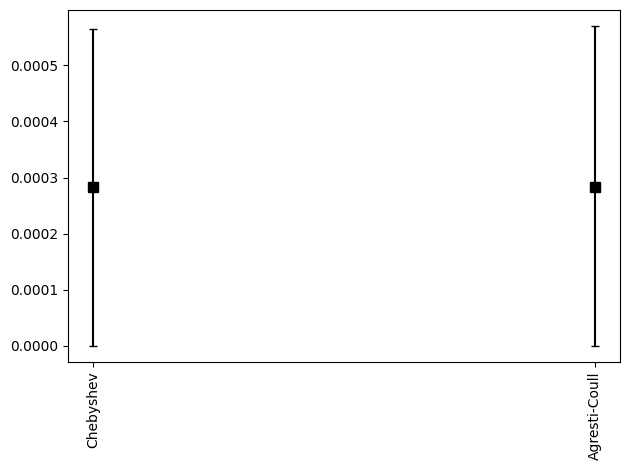

In [14]:
import matplotlib.pyplot as plt
import numpy as np

x_ticks = ("Chebyshev", "Agresti-Coull")

x_1 = [1, 2]

y_1 = [VolR, VolR]

err_1 = [[i1, i2],  [i1ac, i2ac]]

plt.errorbar(x=x_1, y=y_1, yerr=err_1, color="black", capsize=3,
             linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

plt.xticks(x_1, x_ticks, rotation=90)

plt.tight_layout()
plt.show()